# DIVI Intensivregister

## What are we dealing with?
It's a php-generated page containing a table which lists many (not all?) German clinics in a column labeled *Klinikname*. Other columns are labeled *Kontakt* = contact info, *Bundesland* = federal state, [*ICU*](https://en.wikipedia.org/wiki/Intensive_care_unit) *low care*, *ICU high care*, [*ECMO*](https://en.wikipedia.org/wiki/Extracorporeal_membrane_oxygenation) and *Stand* = time stamp. The columns *ICU* and *ECMO* solely contain colored bubbles to illustrate the availability of these resources. The legends explains as follows:

* red = *Verfügbar* = ready
* yellow = *Begrenzt* = limited
* green = *Ausgelastet* = exhausted
* unavailable = unknown state

A form offers sorting and filtering of that table.

## What to contribute?
The table only shows contemporary data as clinics submit their data (time stamp!). Aside to some statistics on that data -- what might be interesting to see is how it develops over time during the [COVID19](https://en.wikipedia.org/wiki/2019%E2%80%9320_coronavirus_pandemic) pandemic.

# Approach

## Fetch data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scrape import scrape, divi

In [2]:
scrape_result = divi.to_dataframe()
scrape_result

,Klinikname,Bundesland,ICU low care,ICU high care,ECMO,COVID-19 cases
Stand,,,,,,
2020-04-03 16:19:04,"Städtisches Klinikum Dresden, Städtisches Klin...",SN,0.5,0.5,0.0,4.0
2020-03-26 13:06:38,"Städtisches Klinikum Dresden, Städtisches Klin...",SN,1.0,0.5,NaN,0.0
2020-03-31 08:58:09,Herzzentrum Dresden,SN,NaN,1.0,1.0,0.0
2020-04-06 16:57:01,Universitätsklinikum Carl Gustav Carus an der ...,SN,1.0,1.0,1.0,6.0
2020-04-02 07:21:37,"ASKLEPIOS-ASB Klinik Radeberg, Asklepios-ASB K...",SN,NaN,0.5,0.0,1.0
...,...,...,...,...,...,...
2020-04-03 05:37:58,"St. Georg Klinikum Eisenach gGmbH, St. Georg K...",TH,1.0,1.0,0.0,3.0
2020-04-03 11:17:44,"Helios Klinikum Gotha, Gotha",TH,1.0,1.0,0.0,0.0
2020-04-03 06:24:41,"Hufeland Klinikum GmbH, Bad Langensalza",TH,1.0,1.0,0.0,0.0


In [3]:
scrape_result.describe()

,ICU low care,ICU high care,ECMO,COVID-19 cases
count,896.000000,937.000000,782.00000,1019.000000
mean,0.891183,0.902348,0.18798,2.777233
std,0.237868,0.226018,0.37931,4.845190
min,0.000000,0.000000,0.00000,0.000000
25%,1.000000,1.000000,0.00000,0.000000
50%,1.000000,1.000000,0.00000,1.000000
75%,1.000000,1.000000,0.00000,4.000000
max,1.000000,1.000000,1.00000,66.000000


Apparently, *St. Marienhospital Vechta gGmbH* has got a double entry.

## Raw data
Next, let's deduplicate and drop the contact info. Additionally, say the colors describe some kind of stress signal, turn colors into float values (red being high and green being low):

|  color        |  float  |
|:--------------|:-------:|
|  red          |   0.0   |
|  yellow       |   0.5   |
|  green        |   1.0   |
|  unavailable  |   NAN   |

In [4]:
df = scrape_result \
.drop_duplicates()
df

,Klinikname,Bundesland,ICU low care,ICU high care,ECMO,COVID-19 cases
Stand,,,,,,
2020-04-03 16:19:04,"Städtisches Klinikum Dresden, Städtisches Klin...",SN,0.5,0.5,0.0,4.0
2020-03-26 13:06:38,"Städtisches Klinikum Dresden, Städtisches Klin...",SN,1.0,0.5,NaN,0.0
2020-03-31 08:58:09,Herzzentrum Dresden,SN,NaN,1.0,1.0,0.0
2020-04-06 16:57:01,Universitätsklinikum Carl Gustav Carus an der ...,SN,1.0,1.0,1.0,6.0
2020-04-02 07:21:37,"ASKLEPIOS-ASB Klinik Radeberg, Asklepios-ASB K...",SN,NaN,0.5,0.0,1.0
...,...,...,...,...,...,...
2020-04-03 05:37:58,"St. Georg Klinikum Eisenach gGmbH, St. Georg K...",TH,1.0,1.0,0.0,3.0
2020-04-03 11:17:44,"Helios Klinikum Gotha, Gotha",TH,1.0,1.0,0.0,0.0
2020-04-03 06:24:41,"Hufeland Klinikum GmbH, Bad Langensalza",TH,1.0,1.0,0.0,0.0


In [5]:
df.describe()

,ICU low care,ICU high care,ECMO,COVID-19 cases
count,896.000000,937.000000,782.00000,1019.000000
mean,0.891183,0.902348,0.18798,2.777233
std,0.237868,0.226018,0.37931,4.845190
min,0.000000,0.000000,0.00000,0.000000
25%,1.000000,1.000000,0.00000,0.000000
50%,1.000000,1.000000,0.00000,1.000000
75%,1.000000,1.000000,0.00000,4.000000
max,1.000000,1.000000,1.00000,66.000000


## Plot average values (per federal state)

Text(0, 0.5, 'federal state')

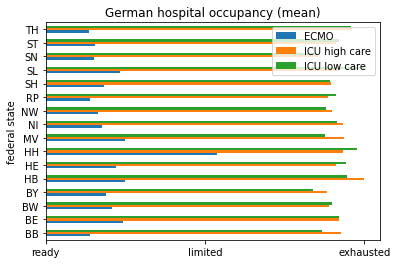

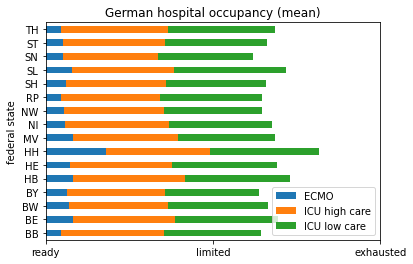

In [6]:
df \
.groupby('Bundesland').mean().reset_index() \
.plot(kind='barh', x='Bundesland', y=['ECMO', 'ICU high care', 'ICU low care'], stacked=False)
plt.title("German hospital occupancy (mean)")
plt.xticks([0.0, 0.5, 1.0],["ready", "limited", "exhausted"])
plt.ylabel("federal state")
df \
.groupby('Bundesland').mean().reset_index() \
.plot(kind='barh', x='Bundesland', y=['ECMO', 'ICU high care', 'ICU low care'], stacked=True)
plt.title("German hospital occupancy (mean)")
plt.xticks([0.0, 1.5, 3.0],["ready", "limited", "exhausted"]) # 3x[0..1] = [0..3]
plt.ylabel("federal state")

So much for contemporary data.

# Historic data
Instead of downloading the data from DIVI we are going to use the old scrapes in `data/divi.tsv`:

In [7]:
#!git pull 2&>1 >/dev/null
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
df = pd \
.read_csv("data/divi.tsv", sep="\t") \
.replace({'NaN': 0.0, 'VERFUEGBAR': 1.0, 'BEGRENZT': 0.5, 'NICHT_VERFUEGBAR': 0.0}) \
.drop_duplicates()
df['Stand'] = pd.to_datetime(df['Stand'], format="%Y-%m-%d %H:%M:%S")
df = df[(df['Stand'] > '2019-12-31') & (df['Stand'] <= datetime.now())].set_index('Stand') \
.drop(columns='COVID-19 cases')
df

,Klinikname,Bundesland,ICU low care,ICU high care,ECMO
Stand,,,,,
2020-03-31 08:58:09,Herzzentrum Dresden,SN,NaN,1.0,1.0
2020-04-05 11:12:27,Universitätsklinikum Carl Gustav Carus an der ...,SN,1.0,1.0,1.0
2020-04-02 07:21:37,"ASKLEPIOS-ASB Klinik Radeberg, Asklepios-ASB K...",SN,NaN,0.5,0.0
2020-03-26 13:14:45,"Sächsisches Krankenhaus Arnsdorf, Arnsdorf",SN,NaN,0.5,NaN
2020-04-05 10:04:46,ELBLAND Reha- und Präventionsklinik Großenhain,SN,0.5,0.5,NaN
...,...,...,...,...,...
2020-04-02 05:44:07,"Katholisches Krankenhaus ""St. Johann Nepomuk"" ...",TH,NaN,1.0,0.0
2020-04-03 06:17:45,Sophien- und Hufeland-Klinikum gGmbH,TH,1.0,1.0,0.0
2020-04-05 06:28:57,Helios Klinik Blankenhain,TH,1.0,1.0,NaN


In [8]:
old = pd.read_csv("data/divi-before-2020-04-04.tsv", sep="\t", index_col=0)
old['Stand'] = pd.to_datetime(old['Stand'], format="%Y-%m-%d %H:%M:%S")
old['Bundesland'] = old['Bundesland'].replace({'NRW': 'NW', '0': 'NW'})
old = old[(old['Stand'] > '2019-12-31') & (old['Stand'] <= datetime.now())] \
.set_index('Stand') \
.drop(columns='Kontakt') \
.drop_duplicates()
old

,Klinikname,Bundesland,ICU low care,ICU high care,ECMO
Stand,,,,,
2020-04-02 21:34:00,"AMEOS Klinik ""Am Bürgerpark"" Bremerhaven",HB,1.0,1.0,NaN
2020-04-02 20:46:00,Klinikum Traunstein,BY,1.0,0.5,NaN
2020-04-02 20:26:00,AMEOS Klinikum Mitte Bremerhaven,HB,1.0,1.0,NaN
2020-04-02 19:55:00,Uniklinik RWTH Aachen - Interdisziplinäre Inte...,NW,0.5,1.0,1.0
2020-04-02 19:14:00,Heliosklinik Lengerich,NW,0.0,1.0,NaN
...,...,...,...,...,...
2020-03-24 09:13:00,Klinikum Ibbenbüren,NW,1.0,0.0,1.0
2020-03-24 09:23:00,AGAPLESION Ev. Bathildiskrankenhaus,NI,1.0,1.0,0.0
2020-03-24 16:42:00,Uniklinik Köln Internistische Intensivstation ...,NW,1.0,0.5,1.0


In [9]:
df = df.append(old).sort_index().drop_duplicates()
df.shape, old.shape

((2144, 5), (1644, 5))

In [10]:
import matplotlib.dates as mdates
from scrape import entorb

federal_state_translation = {
    "BB": "Brandenburg",
    "BE": "Berlin",
    "BW": "Baden-Württemberg",
    "BY": "Bayern",
    "HB": "Bremen",
    "HE": "Hessen",
    "HH": "Hamburg",
    "MV": "Mecklenburg-Vorpommern",
    "NI": "Niedersachsen",
    "NW": "Nordrhein-Westfalen",
    "RP": "Rheinland-Pfalz",
    "SH": "Schleswig-Holstein",
    "SL": "Saarland",
    "SN": "Sachsen",
    "ST": "Sachsen-Anhalt",
    "TH": "Thüringen",
}

columns = ['ICU low care', 'ICU high care', 'ECMO']
federal_states = list(set(df['Bundesland']))
availability = dict()
num_clinics = dict()
infections = dict()
deaths = dict()

# plot each bundesland's total exhaustion
# but also keep each curve in dict bundesland_curves for later correlations
for federal_state in federal_states:    
    clinics_curves_sum = None
    federal_state_clinics = list(set(df[df['Bundesland'] == federal_state]['Klinikname']))
    
    # apply padding to each clinic's curve
    for clinic in federal_state_clinics:
        # use resample() here because we want to correlate day-by-day later
        clinic_curve = df[df['Klinikname'] == clinic] \
        .drop(columns=['Bundesland', 'Klinikname']) \
        .resample("1D").sum()

        # is there something less clumsy from pandas?
        if clinics_curves_sum is None:
            clinics_curves_sum = clinic_curve
        else:
            clinics_curves_sum = clinics_curves_sum.add(clinic_curve, fill_value=0)
    
    availability[federal_state] = clinics_curves_sum
    num_clinics[federal_state] = len(federal_state_clinics)
    #infections[federal_state] = entorb.to_dataframe(federal_state)['Cases_New']
    deaths[federal_state] = entorb.to_dataframe(federal_state)['Deaths_New']
    deaths[federal_state].name = 'deaths'

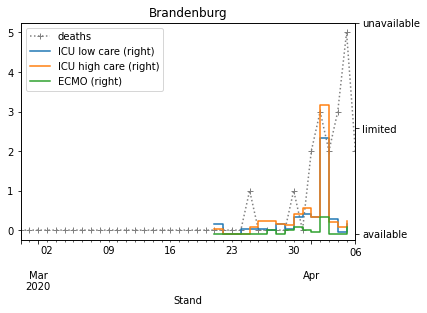

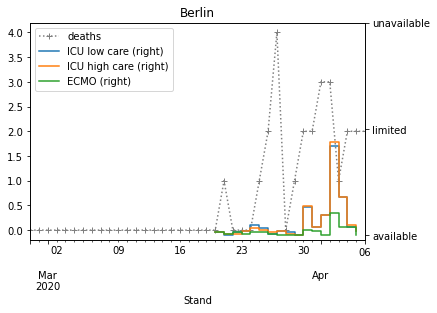

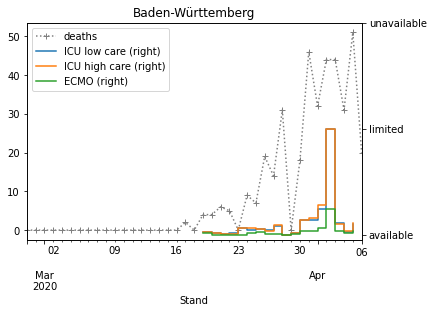

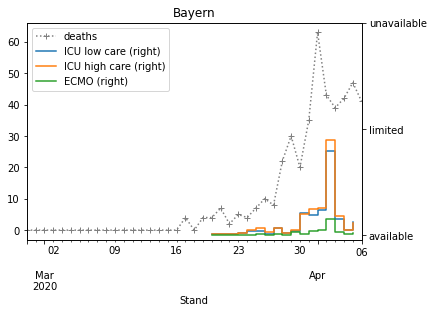

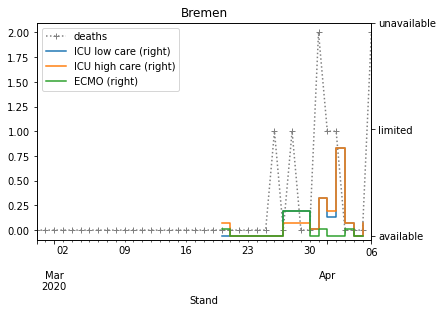

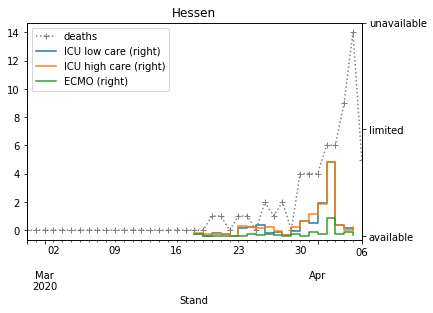

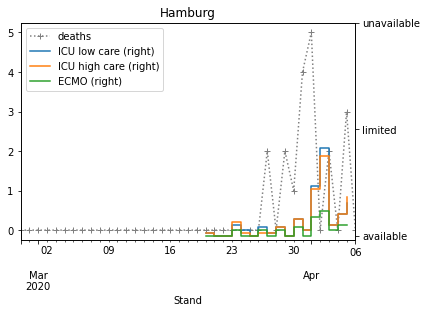

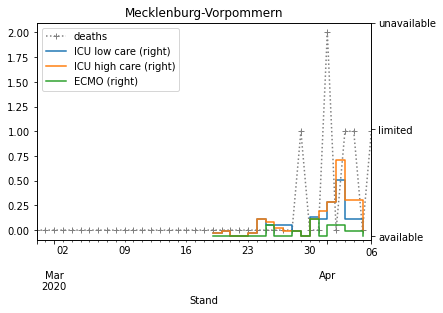

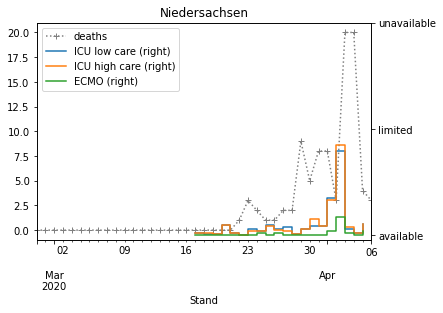

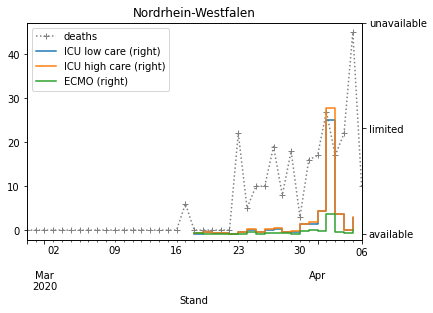

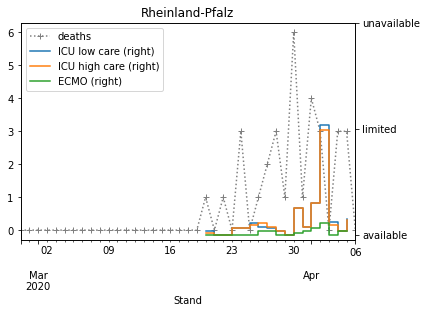

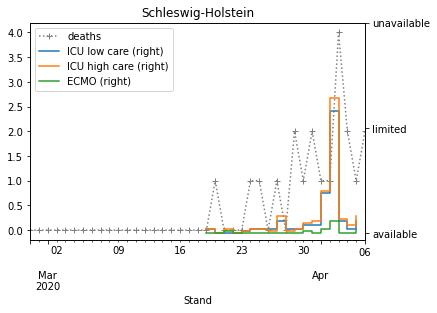

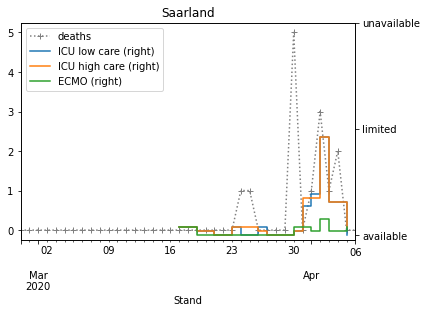

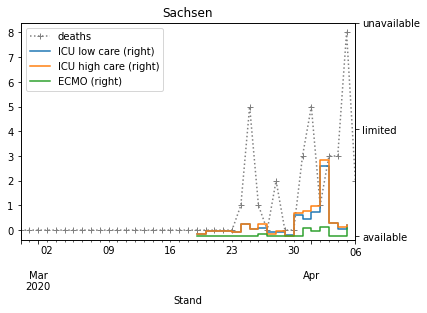

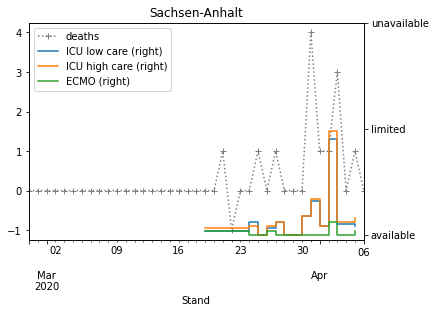

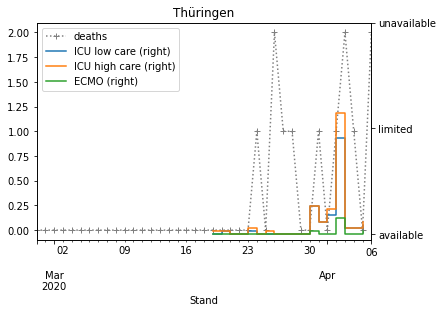

In [11]:
import matplotlib.dates as mdate

for federal_state in sorted(federal_states):
    fig, ax = plt.subplots()
    #infections[federal_state].plot(kind='line', ax=ax, secondary_y=True, color='red', linestyle='-', marker='')
    deaths[federal_state].plot(kind='line', ax=ax, color='grey', linestyle=':', marker='+', legend=True)

    availability[federal_state].plot(kind='line', ax=ax, secondary_y=True, drawstyle='steps-post', marker='')
    plt.yticks([0.0 * num_clinics[federal_state], 
                0.5 * num_clinics[federal_state], 
                1.0 * num_clinics[federal_state]],
               ["available", "limited", "unavailable"])

    plt.title("%s" % federal_state_translation[federal_state])